# План
[1. Импорт библиотек](#no1)<br>
[2. Загрузка данных](#no2)<br>
[3. Первичная аналитика](#no3)<br>
[4. Построение модели](#no4)<br>
[5. Вывод](#no5)<br>

# Условия задачи:

**Данные:**<br>
    • «номер депозита» - это уникальный индификатор депозита, числа от 1 до 100 <br>
    • «номер недели жизни депозита» - числа от 1 до 5 <br>
    • «изменение ставок относительно начала депозита» - это изменение рыночных ставок для депозита с заданным номером и для заданной недели <br>
    • «изменение курса относительно начала депозита» - это изменение рыночного курса рубля для депозита с заданным номером и для заданной недели <br>
    • «объем пополнения» - это объем пополнения для депозита с заданным номером и для заданной недели
    
**Задача:** построить и обосновать регрессионную модель.

<a id="no1"></a>

# 1.  Импорт библиотек

In [177]:
# препроцессинг и работа с первичными данными
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# статистические пакеты
from scipy import stats
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# визуализация
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

<a id="no2"></a>

# 2. Загрузка данных

In [178]:
xlsx = pd.ExcelFile(r'Задачи для кандидатов - для задачи 1.xlsx')
df = xlsx.parse(0)

df = df.rename(columns={'Номер депозита':'N',
                   'Номер недели жизни депозита':'generation',
                   'Изменение ставок  относительно начала депозита':'int_rate',
                   'Изменение курса относительно начала депозита':'ex_rate',
                   'Объем пополнения':'volume'})
df

N  generation  int_rate   ex_rate    volume
0      1           1  0.021498 -0.046133  0.000000
1      1           2  0.019605  0.030865  0.743323
2      1           3  0.082847 -0.013099  0.977405
3      1           4 -0.025355 -0.007046  0.772670
4      1           5 -0.109462 -0.109332  0.039289
..   ...         ...       ...       ...       ...
495  100           1  0.005387 -0.011301  0.007183
496  100           2 -0.092774 -0.144132  0.785305
497  100           3 -0.011375 -0.000458  1.021720
498  100           4 -0.067415 -0.301667  0.768857
499  100           5 -0.092213 -0.164283  0.035602

[500 rows x 5 columns]

<a id="no3"></a>

# 3. Первичная аналитика

## 3.1 QQ-график

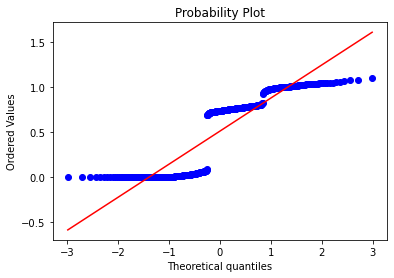

In [179]:
# квантиль-квантильный график - нанесение точек из набора данных 
# в зависимости от значений нормального распределения

fig = plt.figure()
ax = fig.add_subplot()
res = stats.probplot(df.volume, plot=plt)

Значения зависимой переменной *volume* имеют сильный разброс относительно теоретических квантилей нормального распределения.

In [180]:
import plotly.express as px

fig = px.histogram(df, x='volume', width=800, height=400, title='Гистограмма распределения зависимой переменной volume')
fig.show()

## 3.2 Анализ признаков и объяснение зависимостей переменных

In [181]:
fig = px.scatter(df, y='volume', x='ex_rate', width=700, height=400, 
                 title='Влияние курса на пополнения')
fig.show()

Видим 3 основных кластера по величине пополнений:

* на уровне ~1
* на уровне ~0.8
* на уровне 0
    
Но расположены они вдоль практически всего диапазона значений переменной ex_rate. Вероятно, это не самый сильный фактор.

In [182]:
fig = px.scatter(df, x='int_rate', y='volume', width=700, height=400,
                title='Влияние ставок на пополнения')
fig.show()

Похожая ситуация с переменной int_rate. Влияние переменной изменения % ставок относительно начала срока депозита не самое очевидное.

In [183]:
fig = px.scatter(df, y='volume', x='generation', width=700, height=400, 
                 title='Влияние недели жизни на пополнения')
fig.show()

In [184]:
fig = px.box(df, y='volume', points='all', color='generation', title='Влияние недели жизни на пополнения',
            width=700, height=400)
fig.show()

Однако, с переменной "неделя жизни депозита" ситуация обратная. Видим достаточно четкую квадратичную зависимость срока жизни от пополнения. Пик приходится на 3 неделю, затем на 2 и 4 неделю, меньше всего клиенты производят пополнения на 1 и 5 неделе.

**Возможные объяснения:**
1. "Короткие" депозиты юрлица открывают для накопления на какую-либо покупку (например, основных средств, оборудования и т.п.) Клиент открывает депозит с минимальной суммой, имеющейся в распоряжении, затем при наличии свободных средств пополняет депозит на 2 и 4 неделе. Когда на депозите сумма достаточна, клиент не пополняет его и снимает в конце срока.
2. Депозит открывается для сохранения стоимости денежных средств с учетом инфляции (хотя срок и маленьких, но при больших суммах влияние может быть значительное). Логика такая же: клиент открывает депозит с вложением всех доступных средств, потом идет приток cashflow, и клиент сразу пополняет депозит за счет прибыли. Затем, вероятно, переоткрывает депозит.
3. Частая особенность депозитов юридических лиц - короткие сроки и возможность пополнения/снятия. Т.к. бизнесу средства могут пригодиться в любой момент.

Произведем группировку признаков % ставка и обменный курс на бакеты, чтобы посмотреть, в каких из них происходит больше всего пополнений.

In [185]:
def grouping(x):
    grp = ''
    if x <= -0.1: 
        grp = '<-1'
    elif -0.1 < x <= 0: 
        grp = '(-0.1;0]'
    elif 0 < x <= 0.1: 
        grp = '(0;0.1]'
    else: 
        grp = '>0.1'
    return grp

In [186]:
df['int_rate_grp'] = df['int_rate'].apply(lambda x: grouping(x))
df['ex_rate_grp'] = df['ex_rate'].apply(lambda x: grouping(x))
df

N  generation  int_rate   ex_rate    volume int_rate_grp ex_rate_grp
0      1           1  0.021498 -0.046133  0.000000      (0;0.1]    (-0.1;0]
1      1           2  0.019605  0.030865  0.743323      (0;0.1]     (0;0.1]
2      1           3  0.082847 -0.013099  0.977405      (0;0.1]    (-0.1;0]
3      1           4 -0.025355 -0.007046  0.772670     (-0.1;0]    (-0.1;0]
4      1           5 -0.109462 -0.109332  0.039289          <-1         <-1
..   ...         ...       ...       ...       ...          ...         ...
495  100           1  0.005387 -0.011301  0.007183      (0;0.1]    (-0.1;0]
496  100           2 -0.092774 -0.144132  0.785305     (-0.1;0]         <-1
497  100           3 -0.011375 -0.000458  1.021720     (-0.1;0]    (-0.1;0]
498  100           4 -0.067415 -0.301667  0.768857     (-0.1;0]         <-1
499  100           5 -0.092213 -0.164283  0.035602     (-0.1;0]         <-1

[500 rows x 7 columns]

In [187]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1)
fig.update_layout(title='Влияние параметров на объемы пополнений. Гистограмма', width=800, height=400)

fig.add_trace(go.Histogram(y=df.volume, x=df.ex_rate_grp, name='Пополнения vs изменение курса'),
              row=1, col=1)

fig.add_trace(go.Histogram(y=df.volume, x=df.int_rate_grp, name='Пополнения vs изменение ставок'),
              row=2, col=1)

Опять же видим достаточно равномерное распределение по бакетам изменений <0 и >0. Вряд ли эти переменные имеют какое-либо сильное влияние на зависимую переменную. Проверим, имеют ли они взаимную зависимость между собой? Проведем тест на мультиколлинеарность факторов.

## 3.3 Тест на гетероскедастичность

Проведем тест Уайта, он является более универсальным. Для теста возьмем модель со всеми признаками и модель только с признаком *generation* (срок жизни депозита).

In [188]:
f = 'volume~generation+int_rate+ex_rate'
# f = 'volume~generation+int_rate+ex_rate'
model = ols(formula=f, data=df).fit()

In [189]:
white_test = het_white(model.resid, model.model.exog)
labels = ['LM-статистика', 'p-значение LM-теста', 'F-статистика', 'F-тест', 'p-значение']

print(dict(zip(labels, white_test)))

{'LM-статистика': 120.58929411370018, 'p-значение LM-теста': 1.0120824934209388e-21, 'F-статистика': 17.304248462444853, 'F-тест': 6.343442753904431e-25}


Смотрим на p-значения LM-теста или F-теста. Гетероскедастичность выявляется при **p<0.05**. В нашем случае этого не произошло, принимаем гипотезу H0 о гомокедастичности

<a id="no4"></a>

# 4. Построение модели

## 4.1 Бейзлайн линейной регрессии

Построим простую линейную регрессию с учетом всех факторов (в дальнейшем мы изменим этот подход). 

In [190]:
f = ['volume~generation',
     'volume~generation+int_rate',
     'volume~generation+int_rate+ex_rate']

for i in f:
    model = ols(formula=i, data=df).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.001374
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.970
Time:                        17:00:29   Log-Likelihood:                -268.50
No. Observations:                 500   AIC:                             541.0
Df Residuals:                     498   BIC:                             549.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5117      0.044     11.761      0.0

Выше мы посмотрели разные линейные модели постепенно включая новые переменные в нее. Сравниваем по R^2 adj. (т.к. кол-во переменных разное). Во всех трех переменных скорректированный коэф-т детерминации низкий, что означает слабую объясняющую способность такой регресии. Также значение P>|t| указывает на статистическую незначимость коэф-тов.

Для примера посмотрим коэф-ты модели со
Коэф-ты для переменных следующие:
1. Неделя жизни: 0.0010
2. Изменение % ставки: 0.0140
3. Изменение курса: -0.0841

## 4.2 Тест на мультиколлинеарность

In [191]:
vif_data = pd.DataFrame()

X = df[['generation','int_rate','ex_rate']]
vif_data['feature'] = X.columns

vif_data['VIF'] = [vif(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

      feature       VIF
0  generation  1.000147
1    int_rate  2.013365
2     ex_rate  2.013269


По результатам не видим мультиколлинеарности, все значения VIF < 5.

## 4.3 Оптимизация модели

Т.к. ранее мы увидели квадратичную зависимость объема пополнений от недели жизни, попробуем использовать **полиномиальную регрессию** 2 степени.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 6.029e+04
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:00:29   Log-Likelihood:                 1157.2
No. Observations:                 500   AIC:                            -2308.
Df Residuals:                     497   BIC:                            -2296.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0968      0.005   -213.229      0.000      -1.107      -1.087
x1             1.3360      0.004    340.810      0.000       1.328       1.344
x2            -0.2226      0.001   -347.260      0.000      -0.224      -0.221
==============================================================================
Omnibus:                        6.389   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.265
Skew:                           0.270   Prob(JB):                       0.0436
Kurtosis:                       3.097   Cond. No.                         85.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

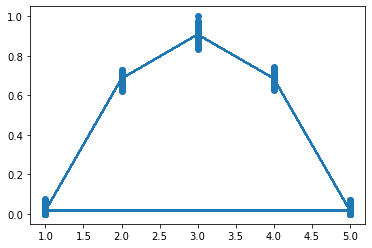

In [192]:
x = df[['generation']]
poly_features = PolynomialFeatures(degree=2)
xp = poly_features.fit_transform(x)
#xp.shape

poly_reg = sm.OLS(y,xp).fit()
ypred = poly_reg.predict(xp) 

ypred.shape

plt.scatter(x,y)
plt.plot(x,ypred)

poly_reg.summary()

В нашей регрессии получилось 2 переменных: generation и generation^2. Показатели R^2 и R^2 adj. на уровне 0.996 - т.е. регрессия на 99.6% объясняется выбранными переменными. p-значение указывает на статистическую значимость переменных. При росте срока жизни депозита до 3 недель пополнения растут. Затем наблюдается их постепенный спад.

<a id="no5"></a>

# 5. Вывод

В ходе выполнения задачи мы выбрали следующую модель:
* Объем пополнений = -1.0968 + 1.3360 * неделя жизни - 0.2226 * неделя жизни^2.

Данная модель наилучшим образом объясняет поведение зависимой переменной (экономическое обоснование см. выше).
По результатам F-теста регрессия в целом значима, t-тест говорит о том, что переменные в отдельности также статистически значимы.